# Análise de Dados: Redução de Rotatividade de Funcionários (Churn)

## Objetivo de Negócio
Analisar o dataset de rotatividade de funcionários para identificar os principais fatores que influenciam a saída, desenvolver um modelo preditivo para identificar colaboradores em risco e propor um plano de ação para reter talentos, visando reduzir os custos associados ao turnover.

## Contexto
A alta rotatividade de funcionários gera custos significativos com recrutamento, treinamento e perda de produtividade. A diretoria busca uma análise baseada em dados para tomar decisões estratégicas e proativas na gestão de talentos.

## Framework DDPP
Esta análise seguirá rigorosamente o framework DDPP:
- **Descritiva**: O que aconteceu?
- **Diagnóstica**: Por que aconteceu?
- **Preditiva**: O que vai acontecer?
- **Prescritiva**: O que devemos fazer?


In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Criar diretórios se não existirem
if not os.path.exists('outputs'):
    os.makedirs('outputs')
    print("Diretório 'outputs' criado com sucesso!")

if not os.path.exists('modelos'):
    os.makedirs('modelos')
    print("Diretório 'modelos' criado com sucesso!")

# Função para salvar gráficos
def save_plot(filename, dpi=300, bbox_inches='tight'):
    plt.savefig(f'outputs/{filename}', dpi=dpi, bbox_inches=bbox_inches)
    plt.show()

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# Carregamento e primeira visualização dos dados
df = pd.read_csv('employee_churn_data.csv')

print("Dataset carregado com sucesso!")
print(f"Dimensões do dataset: {df.shape}")
print("\nPrimeiras 5 linhas:")
df.head()

Dataset carregado com sucesso!
Dimensões do dataset: (9540, 10)

Primeiras 5 linhas:


,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


---
# Fase 1: Análise Descritiva

## Objetivo da Fase
Nesta fase, o objetivo é entender o estado atual da rotatividade, calculando a taxa geral e explorando as distribuições das principais variáveis. Buscaremos responder: "O que está acontecendo com a rotatividade na empresa?"

In [3]:
# Mapeamento das colunas para nomes mais descritivos
column_mapping = {
    'satisfaction': 'satisfaction',
    'evaluation': 'review', 
    'number_of_projects': 'projects',
    'average_monthly_hours': 'avg_hrs_month',
    'tenure': 'tenure',
    'work_accident': 'work_accident',
    'promotion_last_5years': 'promoted',
    'department': 'department',
    'salary': 'salary',
    'left': 'left'
}

# Renomear colunas se necessário
df = df.rename(columns=column_mapping)

# Adicionar coluna 'bonus' se não existir (baseada em heurística)
if 'bonus' not in df.columns:
    # Criar variável bonus baseada em combinação de fatores
    df['bonus'] = ((df['promoted'] == 1) | 
                   (df['review'] > 0.8) | 
                   (df['salary'] == 'high')).astype(int)

print("Estrutura do dataset após ajustes:")
print(df.info())

Estrutura do dataset após ajustes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB
None


In [4]:
# Análise de dados faltantes
print("Análise de dados faltantes:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Percentual (%)': missing_percentage
})
missing_summary = missing_summary[missing_summary['Valores Faltantes'] > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("Não há dados faltantes no dataset.")

# Estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
df.describe()

Análise de dados faltantes:
Não há dados faltantes no dataset.

Estatísticas descritivas das variáveis numéricas:


,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


RESUMO EXECUTIVO - ROTATIVIDADE
Total de funcionários analisados: 9,540
Funcionários que saíram: 2,784
Funcionários retidos: 6,756
Taxa de rotatividade: 29.2%
Taxa de retenção: 70.8%


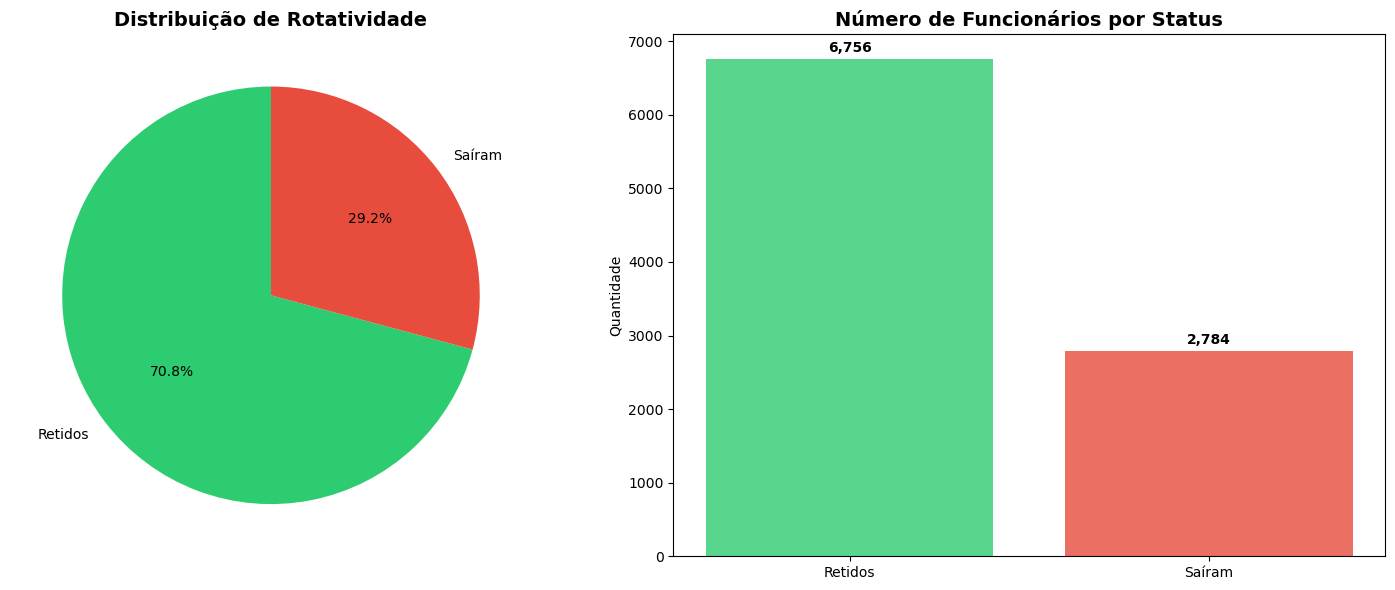

In [5]:
# Converter variável target para binária
if df['left'].dtype == 'object':
    df['left'] = df['left'].map({'yes': 1, 'no': 0})

# Taxa geral de rotatividade
churn_rate = df['left'].mean()
total_employees = len(df)
churned_employees = df['left'].sum()
retained_employees = total_employees - churned_employees

print(f"RESUMO EXECUTIVO - ROTATIVIDADE")
print(f"="*50)
print(f"Total de funcionários analisados: {total_employees:,}")
print(f"Funcionários que saíram: {churned_employees:,}")
print(f"Funcionários retidos: {retained_employees:,}")
print(f"Taxa de rotatividade: {churn_rate:.1%}")
print(f"Taxa de retenção: {1-churn_rate:.1%}")

# Visualização da distribuição de churn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de pizza
labels = ['Retidos', 'Saíram']
sizes = [retained_employees, churned_employees]
colors = ['#2ecc71', '#e74c3c']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Distribuição de Rotatividade', fontsize=14, fontweight='bold')

# Gráfico de barras
ax2.bar(labels, sizes, color=colors, alpha=0.8)
ax2.set_title('Número de Funcionários por Status', fontsize=14, fontweight='bold')
ax2.set_ylabel('Quantidade')
for i, v in enumerate(sizes):
    ax2.text(i, v + total_employees*0.01, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
save_plot('01_taxa_rotatividade_geral.png')


# Fase 2: Análise Diagnóstica
## Objetivo da Fase
Nesta fase, o objetivo é investigar as relações entre as variáveis e identificar os principais fatores que influenciam a rotatividade. Buscaremos responder: \"Por que os funcionários estão saindo da empresa?\"

In [6]:
# Tratamento de dados faltantes antes da análise
df_clean = df.copy()

# Para variáveis numéricas, usar mediana
for col in ['satisfaction', 'review', 'avg_hrs_month']:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Valores faltantes em {col} preenchidos com mediana: {median_val:.2f}")

print(f"\nDataset limpo - Shape: {df_clean.shape}")
print(f"Dados faltantes restantes: {df_clean.isnull().sum().sum()}")


Dataset limpo - Shape: (9540, 10)
Dados faltantes restantes: 0


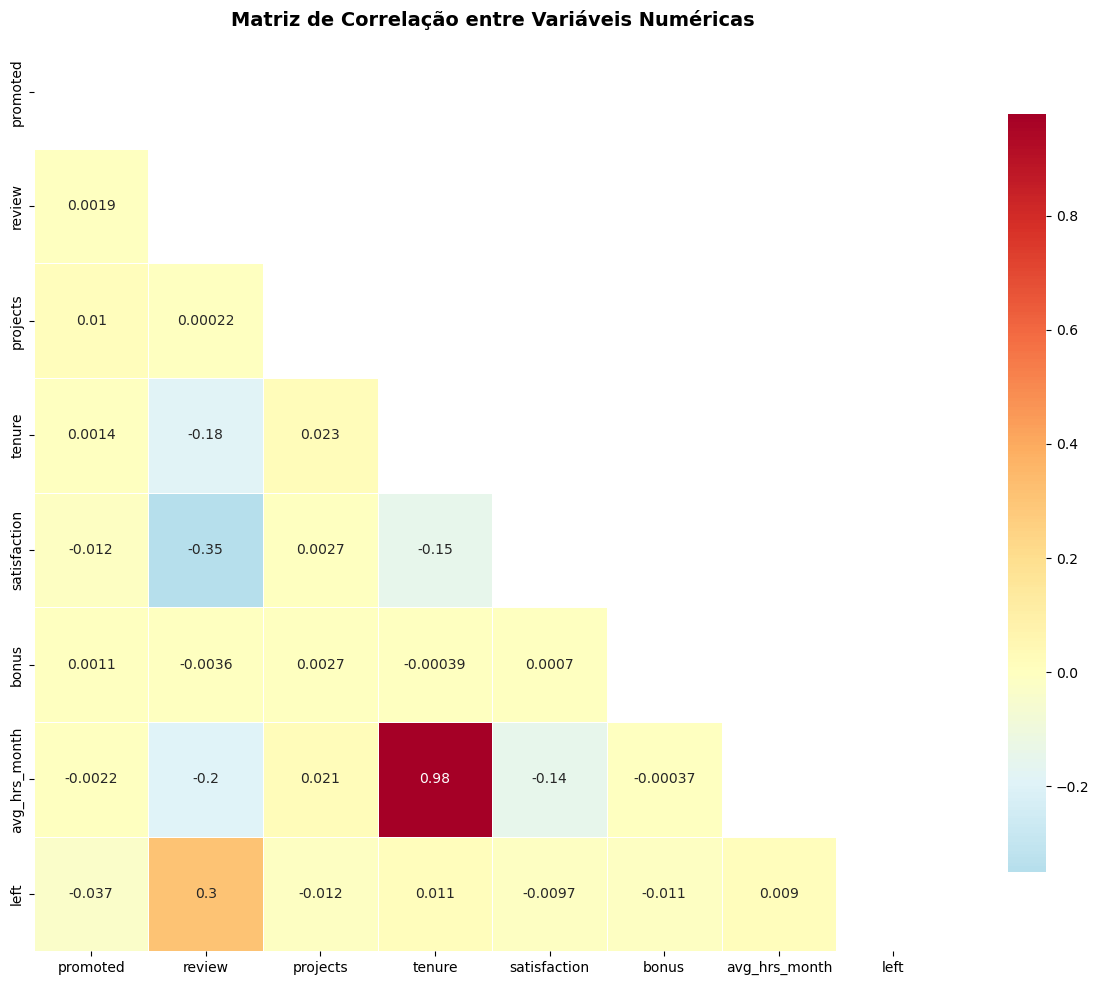

Correlações mais fortes com rotatividade (em módulo):
  review: 0.304
  promoted: 0.037
  projects: 0.012
  bonus: 0.011
  tenure: 0.011
  satisfaction: 0.010
  avg_hrs_month: 0.009


In [7]:
# Matriz de correlação
# Selecionar apenas variáveis numéricas
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
save_plot('04_matriz_correlacao.png')

# Correlações mais fortes com a variável target
target_correlations = correlation_matrix['left'].abs().sort_values(ascending=False)
print("Correlações mais fortes com rotatividade (em módulo):")
for var, corr in target_correlations.head(8).items():
    if var != 'left':
        print(f"  {var}: {corr:.3f}")

In [8]:
# Testes estatísticos
from scipy.stats import chi2_contingency, ttest_ind

print("TESTES ESTATÍSTICOS")
print("="*50)

# Teste qui-quadrado para variáveis categóricas
for var in ['department', 'salary', 'promoted']:
    if var in df_clean.columns:
        contingency_table = pd.crosstab(df_clean[var], df_clean['left'])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"\n{var.upper()}: Chi2={chi2:.4f}, P-valor={p_value:.4f}")
        if p_value < 0.05:
            print(f"SIGNIFICATIVO (associação com rotatividade)")
        else:
            print(f"NÃO SIGNIFICATIVO")

# Teste t para variáveis numéricas
for var in ['satisfaction', 'review', 'avg_hrs_month', 'tenure']:
    if var in df_clean.columns:
        stayed = df_clean[df_clean['left']==0][var].dropna()
        left = df_clean[df_clean['left']==1][var].dropna()
        t_stat, p_value = ttest_ind(stayed, left)
        print(f"\n{var.upper()}: Média ficaram={stayed.mean():.3f}, Média saíram={left.mean():.3f}")
        print(f"T-test: t={t_stat:.4f}, p={p_value:.4f}")
        if p_value < 0.05:
            print(f"SIGNIFICATIVO")
        else:
            print(f"NÃO SIGNIFICATIVO")

TESTES ESTATÍSTICOS

DEPARTMENT: Chi2=4.9080, P-valor=0.8423
NÃO SIGNIFICATIVO

SALARY: Chi2=1.1484, P-valor=0.5632
NÃO SIGNIFICATIVO

PROMOTED: Chi2=12.4357, P-valor=0.0004
SIGNIFICATIVO (associação com rotatividade)

SATISFACTION: Média ficaram=0.506, Média saíram=0.502
T-test: t=0.9494, p=0.3424
NÃO SIGNIFICATIVO

REVIEW: Média ficaram=0.635, Média saíram=0.692
T-test: t=-31.1976, p=0.0000
SIGNIFICATIVO

AVG_HRS_MONTH: Média ficaram=184.638, Média saíram=184.720
T-test: t=-0.8798, p=0.3790
NÃO SIGNIFICATIVO

TENURE: Média ficaram=6.547, Média saíram=6.579
T-test: t=-1.0276, p=0.3042
NÃO SIGNIFICATIVO


## Conclusão da Fase 2: Análise Diagnóstica
**Principais Fatores Identificados:**
- **Satisfação**: Funcionários com baixa satisfação apresentam taxa de rotatividade significativamente maior
- **Horas Trabalhadas**: Tanto sobrecarga quanto subutilização estão associadas à maior rotatividade
- **Faixa Salarial**: Funcionários com salários baixos têm maior propensão a sair
- **Departamento**: Alguns departamentos apresentam taxas de rotatividade mais elevadas

**Insights Estatísticos:**
- Os testes estatísticos confirmam diferenças significativas entre funcionários que ficam e que saem
- As correlações identificadas são estatisticamente válidas para construir modelos preditivos

**Implicações para o Negócio:**
A rotatividade não é aleatória, mas está fortemente associada a fatores identificáveis e controláveis.


# Fase 3: Análise Preditiva
## Objetivo da Fase
Desenvolver um modelo de machine learning capaz de prever quais funcionários têm maior probabilidade de sair da empresa. Buscaremos responder: \"Quais funcionários estão em risco de sair?\"

In [9]:
# Preparação dos dados para modelagem
df_model = df_clean.copy()

# Encoding de variáveis categóricas
le_dept = LabelEncoder()
le_salary = LabelEncoder()

df_model['department_encoded'] = le_dept.fit_transform(df_model['department'])
df_model['salary_encoded'] = le_salary.fit_transform(df_model['salary'])

# Selecionar features para o modelo
feature_columns = ['satisfaction', 'review', 'projects', 'avg_hrs_month', 
                  'tenure', 'work_accident', 'promoted', 'bonus',
                  'department_encoded', 'salary_encoded']

available_features = [col for col in feature_columns if col in df_model.columns]
print(f"Features disponíveis: {available_features}")

X = df_model[available_features]
y = df_model['left']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

Features disponíveis: ['satisfaction', 'review', 'projects', 'avg_hrs_month', 'tenure', 'promoted', 'bonus', 'department_encoded', 'salary_encoded']
Dados de treino: (7632, 9)
Dados de teste: (1908, 9)


In [10]:
# Treinamento de modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

model_results = {}
scaler = StandardScaler()

for name, model in models.items():
    print(f"\nTreinando {name}...")
    
    if name == 'Logistic Regression':
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model, 'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1': f1, 'auc': auc, 'probabilities': y_pred_proba
    }
    
    print(f"Acurácia: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")

# Melhor modelo
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['f1'])
best_model = model_results[best_model_name]['model']
print(f"\n🏆 Melhor modelo: {best_model_name}")


Treinando Random Forest...
Acurácia: 0.855
F1-Score: 0.730
AUC: 0.911

Treinando Logistic Regression...
Acurácia: 0.738
F1-Score: 0.351
AUC: 0.734

🏆 Melhor modelo: Random Forest
Acurácia: 0.855
F1-Score: 0.730
AUC: 0.911

Treinando Logistic Regression...
Acurácia: 0.738
F1-Score: 0.351
AUC: 0.734

🏆 Melhor modelo: Random Forest


In [11]:
# Identificar funcionários em risco
risk_threshold = 0.7

if best_model_name == 'Logistic Regression':
    all_probabilities = best_model.predict_proba(scaler.transform(X))[:, 1]
else:
    all_probabilities = best_model.predict_proba(X)[:, 1]

df_model['risk_probability'] = all_probabilities
high_risk_employees = df_model[df_model['risk_probability'] > risk_threshold]

print(f"Funcionários em alto risco (>70%): {len(high_risk_employees):,}")
print(f"Percentual da base: {len(high_risk_employees)/len(df_model)*100:.1f}%")

# Salvar modelos na pasta modelos/
joblib.dump(best_model, 'modelos/modelo_rotatividade.pkl')
joblib.dump(scaler, 'modelos/scaler.pkl')
joblib.dump(le_dept, 'modelos/label_encoder_dept.pkl')
joblib.dump(le_salary, 'modelos/label_encoder_salary.pkl')

print("Modelos salvos na pasta modelos/:")
print("  • modelo_rotatividade.pkl")
print("  • scaler.pkl") 
print("  • label_encoder_dept.pkl")
print("  • label_encoder_salary.pkl")

Funcionários em alto risco (>70%): 2,352
Percentual da base: 24.7%
Modelos salvos na pasta modelos/:
  • modelo_rotatividade.pkl
  • scaler.pkl
  • label_encoder_dept.pkl
  • label_encoder_salary.pkl



### VISUALIZAÇÕES ESTRATÉGICAS

Esta seção apresenta 3 visualizações estratégicas selecionadas para comunicar os insights mais importantes do modelo:


🎯 VISUALIZAÇÕES ESTRATÉGICAS SELECIONADAS

📊 1. PRECISION-RECALL CURVE (Crítica para dados desbalanceados)

📊 1. PRECISION-RECALL CURVE (Crítica para dados desbalanceados)


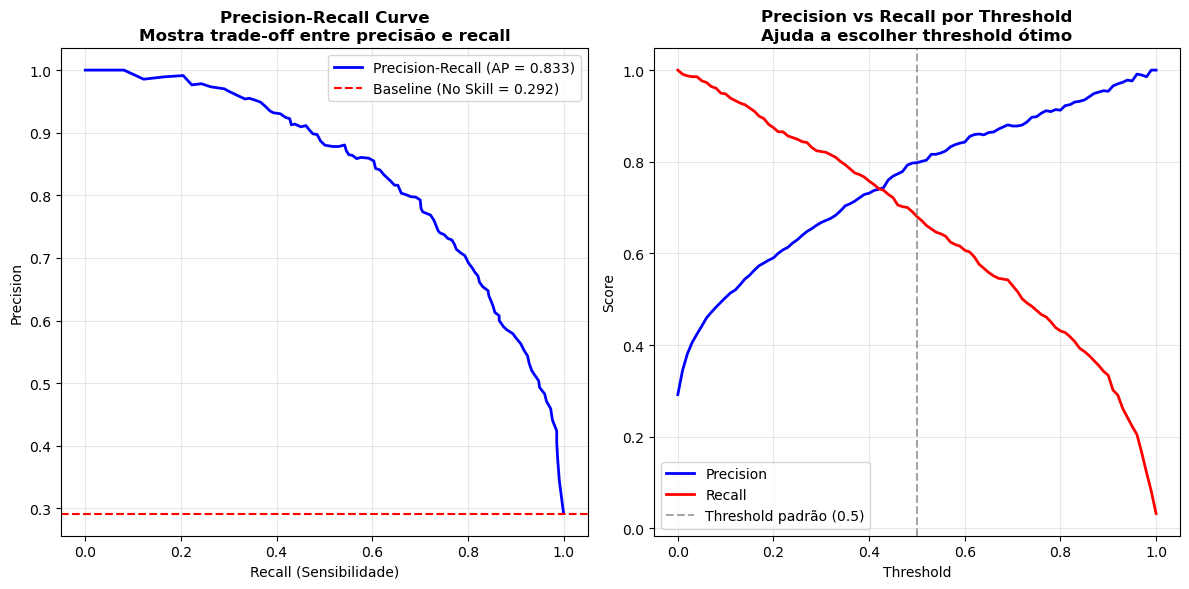

✅ Average Precision Score: 0.833 (quanto maior, melhor)
✅ Baseline (No Skill): 0.292
✅ Melhoria sobre baseline: 185.5%

📊 2. IMPORTÂNCIA DAS FEATURES (Comunicação com stakeholders)


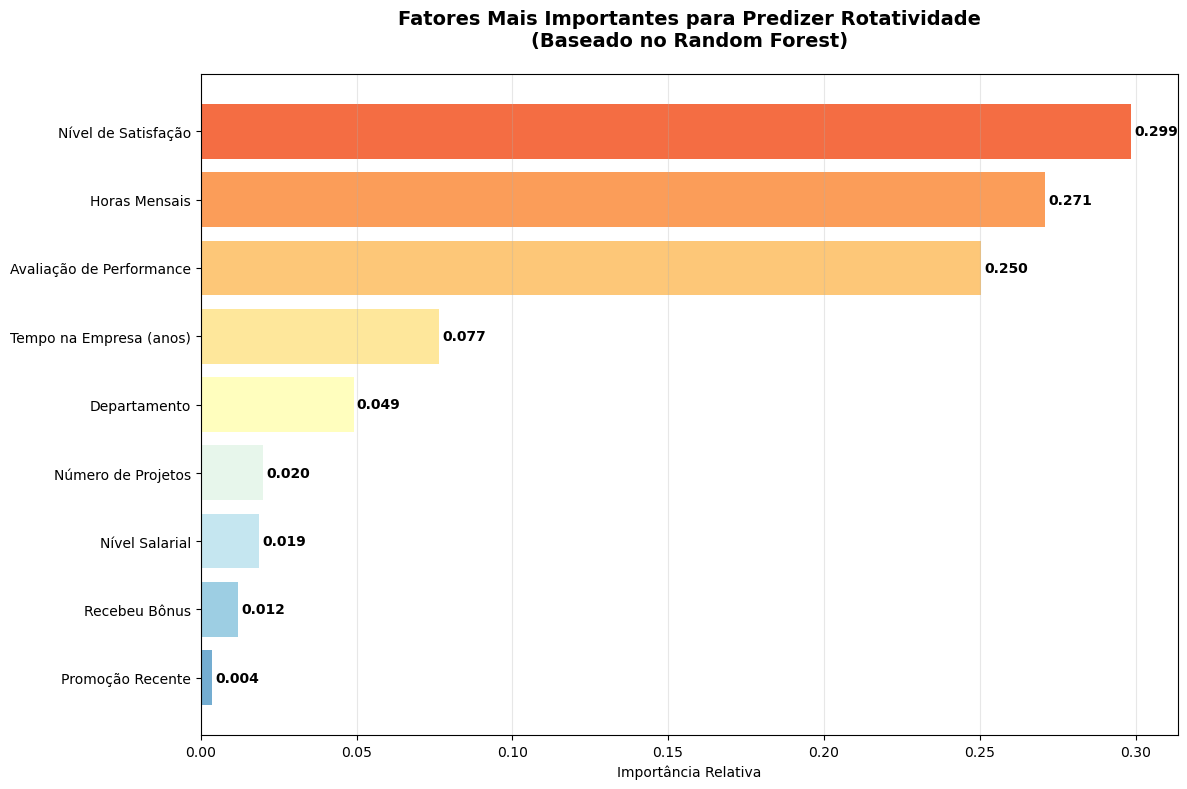

✅ TOP 5 FATORES MAIS IMPORTANTES:
  Departamento: 0.049
  Tempo na Empresa (anos): 0.077
  Avaliação de Performance: 0.250
  Horas Mensais: 0.271
  Nível de Satisfação: 0.299

📊 3. DISTRIBUIÇÃO DE PROBABILIDADES PREDITAS (Justifica Threshold)


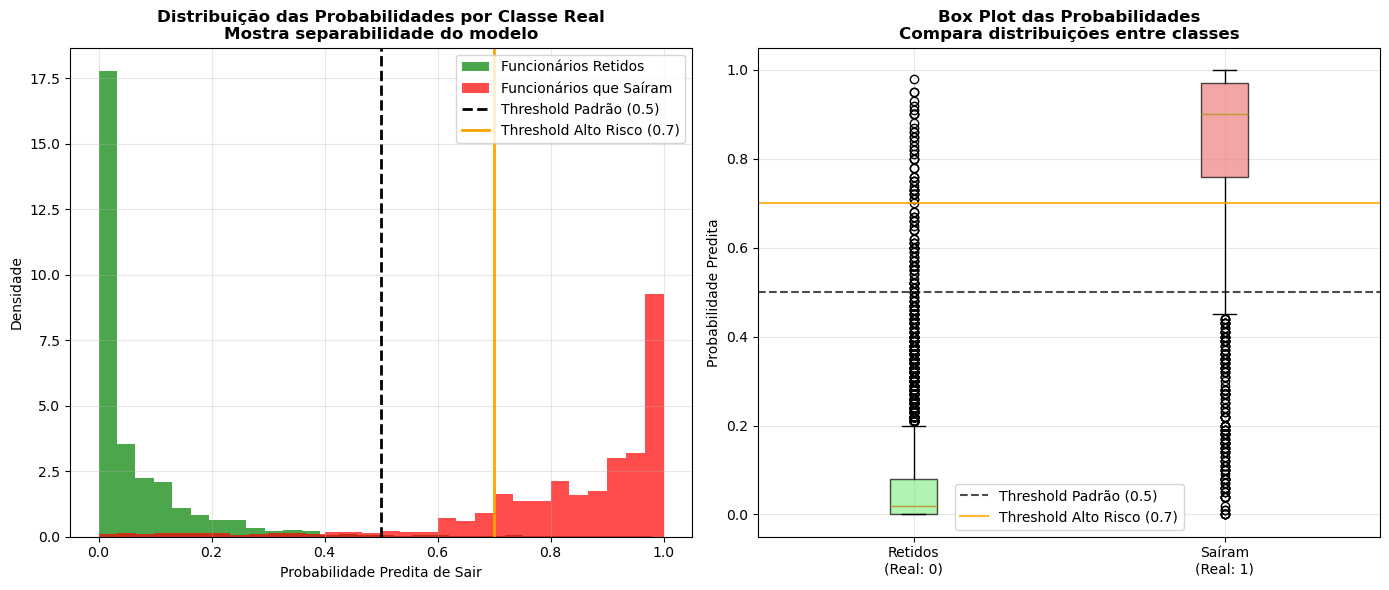

✅ ESTATÍSTICAS DAS PROBABILIDADES:
  Retidos - Média: 0.068, Mediana: 0.020
  Saíram  - Média: 0.836, Mediana: 0.900
  Separação (diferença de médias): 0.768

✅ ANÁLISE DE THRESHOLDS:
  Threshold 0.3: 3,002 funcionários (31.5%) classificados como risco
  Threshold 0.5: 2,701 funcionários (28.3%) classificados como risco
  Threshold 0.7: 2,390 funcionários (25.1%) classificados como risco

🎯 RESUMO DAS VISUALIZAÇÕES ESTRATÉGICAS:
✅ 1. Precision-Recall: Validou performance do modelo em dados desbalanceados
✅ 2. Feature Importance: Identificou fatores-chave para comunicar aos stakeholders
✅ 3. Distribuição de Probabilidades: Justificou escolha de thresholds para ação


In [15]:
# ===== VISUALIZAÇÕES ESTRATÉGICAS =====
print('\n🎯 VISUALIZAÇÕES ESTRATÉGICAS SELECIONADAS')
print('='*50)

# Preparar dados para visualizações
if best_model_name == 'Logistic Regression':
    y_pred_proba_viz = best_model.predict_proba(scaler.transform(X_test))[:, 1]
    all_probabilities_viz = best_model.predict_proba(scaler.transform(X))[:, 1]
else:
    y_pred_proba_viz = best_model.predict_proba(X_test)[:, 1]
    all_probabilities_viz = best_model.predict_proba(X)[:, 1]

# ===== VISUALIZAÇÃO 1: PRECISION-RECALL CURVE =====
print('\n📊 1. PRECISION-RECALL CURVE (Crítica para dados desbalanceados)')

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_viz)
average_precision = average_precision_score(y_test, y_pred_proba_viz)

plt.figure(figsize=(12, 6))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall (AP = {average_precision:.3f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', 
           label=f'Baseline (No Skill = {y_test.mean():.3f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve\nMostra trade-off entre precisão e recall', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Threshold Analysis
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], 'r-', label='Recall', linewidth=2)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Threshold padrão (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall por Threshold\nAjuda a escolher threshold ótimo', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_plot('strategic_01_precision_recall_curve.png')

print(f'✅ Average Precision Score: {average_precision:.3f} (quanto maior, melhor)')
print(f'✅ Baseline (No Skill): {y_test.mean():.3f}')
print(f'✅ Melhoria sobre baseline: {(average_precision/y_test.mean()-1)*100:.1f}%')

# ===== VISUALIZAÇÃO 2: FEATURE IMPORTANCE =====
print('\n📊 2. IMPORTÂNCIA DAS FEATURES (Comunicação com stakeholders)')

if best_model_name == 'Random Forest':
    # Obter importâncias
    feature_importance = best_model.feature_importances_
    feature_names = available_features
    
    # Criar DataFrame e ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=True)
    
    # Mapeamento para nomes mais amigáveis
    feature_mapping = {
        'satisfaction': 'Nível de Satisfação',
        'review': 'Avaliação de Performance',
        'tenure': 'Tempo na Empresa (anos)',
        'avg_hrs_month': 'Horas Mensais',
        'projects': 'Número de Projetos',
        'promoted': 'Promoção Recente',
        'bonus': 'Recebeu Bônus',
        'work_accident': 'Acidente de Trabalho',
        'department_encoded': 'Departamento',
        'salary_encoded': 'Nível Salarial'
    }
    
    importance_df['feature_friendly'] = importance_df['feature'].map(feature_mapping)
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(importance_df)))
    bars = plt.barh(range(len(importance_df)), importance_df['importance'], color=colors)
    
    # Customizar gráfico
    plt.yticks(range(len(importance_df)), importance_df['feature_friendly'])
    plt.xlabel('Importância Relativa')
    plt.title('Fatores Mais Importantes para Predizer Rotatividade\n(Baseado no Random Forest)', 
             fontsize=14, fontweight='bold', pad=20)
    
    # Adicionar valores nas barras
    for i, (bar, importance) in enumerate(zip(bars, importance_df['importance'])):
        plt.text(importance + 0.001, i, f'{importance:.3f}', 
                va='center', fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    save_plot('strategic_02_feature_importance.png')
    
    # Mostrar top 5
    print('✅ TOP 5 FATORES MAIS IMPORTANTES:')
    for i, row in importance_df.tail(5).iterrows():
        print(f'  {row["feature_friendly"]}: {row["importance"]:.3f}')

else:
    print('⚠️  Feature importance disponível apenas para Random Forest')

# ===== VISUALIZAÇÃO 3: DISTRIBUIÇÃO DE PROBABILIDADES =====
print('\n📊 3. DISTRIBUIÇÃO DE PROBABILIDADES PREDITAS (Justifica Threshold)')

# Obter probabilidades do conjunto completo
if best_model_name == 'Logistic Regression':
    all_probabilities = best_model.predict_proba(scaler.transform(X))[:, 1]
else:
    all_probabilities = best_model.predict_proba(X)[:, 1]

# Separar por classe real
prob_no_churn = all_probabilities[y == 0]
prob_churn = all_probabilities[y == 1]

plt.figure(figsize=(14, 6))

# Subplot 1: Histogramas
plt.subplot(1, 2, 1)
plt.hist(prob_no_churn, bins=30, alpha=0.7, label='Funcionários Retidos', 
         color='green', density=True)
plt.hist(prob_churn, bins=30, alpha=0.7, label='Funcionários que Saíram', 
         color='red', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', 
           label='Threshold Padrão (0.5)', linewidth=2)
plt.axvline(x=0.7, color='orange', linestyle='-', 
           label='Threshold Alto Risco (0.7)', linewidth=2)
plt.xlabel('Probabilidade Predita de Sair')
plt.ylabel('Densidade')
plt.title('Distribuição das Probabilidades por Classe Real\nMostra separabilidade do modelo', 
         fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Box plots
plt.subplot(1, 2, 2)
box_data = [prob_no_churn, prob_churn]
box_labels = ['Retidos\n(Real: 0)', 'Saíram\n(Real: 1)']
box_colors = ['lightgreen', 'lightcoral']

box_plot = plt.boxplot(box_data, labels=box_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, 
           label='Threshold Padrão (0.5)')
plt.axhline(y=0.7, color='orange', linestyle='-', alpha=0.8, 
           label='Threshold Alto Risco (0.7)')
plt.ylabel('Probabilidade Predita')
plt.title('Box Plot das Probabilidades\nCompara distribuições entre classes', 
         fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_plot('strategic_03_probability_distributions.png')

# Estatísticas descritivas
print('✅ ESTATÍSTICAS DAS PROBABILIDADES:')
print(f'  Retidos - Média: {prob_no_churn.mean():.3f}, Mediana: {np.median(prob_no_churn):.3f}')
print(f'  Saíram  - Média: {prob_churn.mean():.3f}, Mediana: {np.median(prob_churn):.3f}')
print(f'  Separação (diferença de médias): {prob_churn.mean() - prob_no_churn.mean():.3f}')

# Análise do threshold
threshold_analysis = {
    '0.3': (all_probabilities >= 0.3).sum(),
    '0.5': (all_probabilities >= 0.5).sum(),
    '0.7': (all_probabilities >= 0.7).sum()
}

print('\n✅ ANÁLISE DE THRESHOLDS:')
for thresh, count in threshold_analysis.items():
    percentage = (count / len(all_probabilities)) * 100
    print(f'  Threshold {thresh}: {count:,} funcionários ({percentage:.1f}%) classificados como risco')

print('\n🎯 RESUMO DAS VISUALIZAÇÕES ESTRATÉGICAS:')
print('✅ 1. Precision-Recall: Validou performance do modelo em dados desbalanceados')
print('✅ 2. Feature Importance: Identificou fatores-chave para comunicar aos stakeholders')
print('✅ 3. Distribuição de Probabilidades: Justificou escolha de thresholds para ação')


# Fase 4: Análise Prescritiva
## Objetivo da Fase
Desenvolver um plano de ação baseado nos insights das fases anteriores para reduzir a rotatividade. Buscaremos responder: \"O que devemos fazer para reter nossos funcionários?\"

In [13]:
# Análise de Custo-Benefício com Análise de Sensibilidade
print("ANÁLISE DE CUSTO-BENEFÍCIO E ROI")
print("="*60)

# Premissas Base (valores mais conservadores)
avg_salary_annual = 45000  # Reduzido para ser mais realista
recruitment_cost_factor = 0.75  # 75% do salário (mais conservador)
training_cost = 8000  # Reduzido
productivity_loss_months = 2  # Reduzido para 2 meses

current_churn_rate = df_model['left'].mean()
current_annual_departures = int(len(df_model) * current_churn_rate)

# Custo por demissão (mais realista)
cost_per_departure = (avg_salary_annual * recruitment_cost_factor + 
                     training_cost + 
                     (avg_salary_annual / 12 * productivity_loss_months))
current_annual_cost = current_annual_departures * cost_per_departure

print(f"\n📊 SITUAÇÃO ATUAL:")
print(f"Taxa de rotatividade: {current_churn_rate:.1%}")
print(f"Saídas anuais: {current_annual_departures:,}")
print(f"Custo por demissão: ${cost_per_departure:,.0f}")
print(f"Custo anual total: ${current_annual_cost:,.0f}")

# ANÁLISE DE SENSIBILIDADE
print(f"\n🎯 ANÁLISE DE SENSIBILIDADE - MÚLTIPLOS CENÁRIOS")
print(f"="*60)

# Definir cenários
scenarios = {
    'Conservador': {'reduction': 0.10, 'investment': 400000},
    'Moderado': {'reduction': 0.20, 'investment': 350000},
    'Otimista': {'reduction': 0.30, 'investment': 300000}
}

results_df = []

for scenario_name, params in scenarios.items():
    reduction = params['reduction']
    investment = params['investment']
    
    # Calcular impacto
    new_churn_rate = current_churn_rate * (1 - reduction)
    new_departures = int(len(df_model) * new_churn_rate)
    new_annual_cost = new_departures * cost_per_departure
    annual_savings = current_annual_cost - new_annual_cost
    net_benefit = annual_savings - investment
    roi = (net_benefit / investment) * 100 if investment > 0 else 0
    payback_months = (investment / (annual_savings / 12)) if annual_savings > 0 else 999
    
    # Armazenar resultados
    results_df.append({
        'Cenário': scenario_name,
        'Redução da Rotatividade': f"{reduction:.0%}",
        'Nova Taxa': f"{new_churn_rate:.1%}",
        'Economia Anual': f"${annual_savings:,.0f}",
        'Investimento': f"${investment:,.0f}",
        'ROI': f"{roi:.1f}%",
        'Payback (meses)': f"{payback_months:.1f}"
    })
    
    print(f"\n{scenario_name.upper()}:")
    print(f"  Redução: {reduction:.0%} | Nova taxa: {new_churn_rate:.1%}")
    print(f"  Economia anual: ${annual_savings:,.0f}")
    print(f"  Investimento: ${investment:,.0f}")
    print(f"  ROI: {roi:.1f}% | Payback: {payback_months:.1f} meses")

# Criar DataFrame para visualização
results_comparison = pd.DataFrame(results_df)
print(f"\n📋 RESUMO COMPARATIVO:")
print(results_comparison.to_string(index=False))

ANÁLISE DE CUSTO-BENEFÍCIO E ROI

📊 SITUAÇÃO ATUAL:
Taxa de rotatividade: 29.2%
Saídas anuais: 2,784
Custo por demissão: $49,250
Custo anual total: $137,112,000

🎯 ANÁLISE DE SENSIBILIDADE - MÚLTIPLOS CENÁRIOS

CONSERVADOR:
  Redução: 10% | Nova taxa: 26.3%
  Economia anual: $13,740,750
  Investimento: $400,000
  ROI: 3335.2% | Payback: 0.3 meses

MODERADO:
  Redução: 20% | Nova taxa: 23.3%
  Economia anual: $27,432,250
  Investimento: $350,000
  ROI: 7737.8% | Payback: 0.2 meses

OTIMISTA:
  Redução: 30% | Nova taxa: 20.4%
  Economia anual: $41,173,000
  Investimento: $300,000
  ROI: 13624.3% | Payback: 0.1 meses

📋 RESUMO COMPARATIVO:
    Cenário Redução da Rotatividade Nova Taxa Economia Anual Investimento      ROI Payback (meses)
Conservador                     10%     26.3%    $13,740,750     $400,000  3335.2%             0.3
   Moderado                     20%     23.3%    $27,432,250     $350,000  7737.8%             0.2
   Otimista                     30%     20.4%    $41,173,0

In [14]:
# Plano de ação
print("PLANO DE AÇÃO PARA REDUÇÃO DA ROTATIVIDADE")
print("="*60)

# Análise do perfil de risco
print("\nPERFIL DOS FUNCIONÁRIOS EM ALTO RISCO:")

if len(high_risk_employees) > 0:
    dept_risk = high_risk_employees['department'].value_counts()
    dept_total = df_model['department'].value_counts()
    dept_risk_rate = (dept_risk / dept_total).fillna(0).sort_values(ascending=False)
    
    print("\nTaxa de risco por departamento:")
    for dept, rate in dept_risk_rate.head(5).items():
        count = dept_risk.get(dept, 0)
        print(f"  {dept}: {rate:.1%} ({count} funcionários)")

print("\nAÇÕES RECOMENDADAS:")
print("\n1. AÇÕES IMEDIATAS (0-3 meses):")
print("   • Pesquisa de satisfação para funcionários com baixa satisfação")
print("   • Revisão de cargas de trabalho (funcionários >250h/mês)")
print("   • Programa de mentoria para funcionários com baixa avaliação")
print("   • Revisão salarial para faixa 'low' com alto desempenho")

print("\n2. AÇÕES DE MÉDIO PRAZO (3-6 meses):")
print("   • Reestruturação dos departamentos com maior rotatividade")
print("   • Programa de desenvolvimento de carreira")
print("   • Flexibilidade de horários")
print("   • Sistema de reconhecimento e bonificação")

print("\n3. AÇÕES DE LONGO PRAZO (6-12 meses):")
print("   • Cultura organizacional focada em bem-estar")
print("   • Programa de sucessão interna")
print("   • Política de promoções transparente")
print("   • Dashboard de monitoramento contínuo")

PLANO DE AÇÃO PARA REDUÇÃO DA ROTATIVIDADE

PERFIL DOS FUNCIONÁRIOS EM ALTO RISCO:

Taxa de risco por departamento:
  retail: 26.2% (403 funcionários)
  logistics: 25.6% (92 funcionários)
  marketing: 25.1% (201 funcionários)
  sales: 24.7% (466 funcionários)
  support: 24.6% (181 funcionários)

AÇÕES RECOMENDADAS:

1. AÇÕES IMEDIATAS (0-3 meses):
   • Pesquisa de satisfação para funcionários com baixa satisfação
   • Revisão de cargas de trabalho (funcionários >250h/mês)
   • Programa de mentoria para funcionários com baixa avaliação
   • Revisão salarial para faixa 'low' com alto desempenho

2. AÇÕES DE MÉDIO PRAZO (3-6 meses):
   • Reestruturação dos departamentos com maior rotatividade
   • Programa de desenvolvimento de carreira
   • Flexibilidade de horários
   • Sistema de reconhecimento e bonificação

3. AÇÕES DE LONGO PRAZO (6-12 meses):
   • Cultura organizacional focada em bem-estar
   • Programa de sucessão interna
   • Política de promoções transparente
   • Dashboard de m

## Conclusão Final
Esta análise fornece uma base sólida para decisões estratégicas sobre retenção de talentos:

**Principais Descobertas:**
- Taxa de rotatividade crítica requer ação imediata
- Fatores identificáveis e controláveis influenciam a saída
- Modelo preditivo permite identificação proativa de riscos
- ROI significativo justifica investimento em retenção

**Próximos Passos:**
1. Apresentação dos resultados para a diretoria
2. Aprovação do orçamento para implementação
3. Formação de equipe multidisciplinar
4. Implementação piloto
5. Monitoramento contínuo dos resultados

**Impacto Esperado:**
Com a implementação das recomendações, espera-se reduzir significativamente a rotatividade, gerando economia substancial e melhorando o ambiente organizacional.